In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 
from sklearn.decomposition import PCA
from astropy.table import Table, Column
import sys
sys.path.insert(0, '/home/reza/erq/')
from erqml  import *
from sklearn.cluster import AgglomerativeClustering
from sklearn import svm
import sys
sys.path.insert(0, '/home/reza/erq')

from scipy import interpolate
import pyfits
import math
import scipy.ndimage
from scipy import interpolate
from numpy import nanmean
from numpy import nanmedian
from readSDSSspectrafast import *
from erqml import *
from tqdm import notebook
import os
import sys
sys.path.insert(0, '/home/reza/erq')
from scipy import interpolate
import pyfits
from numpy import *
import math
import scipy.ndimage
import numpy as np
from erqml import *
from scipy import ndimage
# from line_db import line_db
import os

/home/reza/anaconda3/lib/python3.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
def scale(x):

        y= x - np.mean(x)
        y = y/np.std(x)
        return y, np.mean(x), np.std(x)

In [3]:
# reading ...
smp=Table.read('/home/reza/erq/sampling/LM_sample.fits') 

iW3 = smp['i-w3']
FW3Fi = 10**(iW3/2.5)
W3 = smp['ABw3']
# iW3 = 10.0**(iW3/2.5)
kt80 = smp['kurt80_gf']
rew = smp['rew_gf']
# rew=np.log10(rew)
fwhm = smp['fwhm_gf'] 
# fwhm=np.log10(fwhm)
N5_C4 = smp['frat_nv/civ']
Lum = smp['Lum']
iz=smp['i-w3'] - smp['r-w3']+smp['r-z']
sdss_name=smp['sdss_name']
z_dr12=smp['z_dr12']
plate = smp['Plate']
mjd = smp['MJD']
fiberid= smp['FiberID']
bal_flag_vi=smp['bal_flag_vi']
iW3_sc,m1,s1 = scale(iW3)
rew_sc,m2,s2 = scale(rew)
kt80_sc,a,b = scale(kt80)
fwhm_sc,a,b = scale(fwhm)
N5_C4_sc,a,b = scale(N5_C4)
# iz_sc,a,b = scale(iz)
smp.columns

<TableColumns names=('sdss_name','Plate','MJD','FiberID','ThingID','z_dr12','snr_1700','snr_spec','bal_flag_vi','bi_civ','err_bi_civ','ai_civ','err_ai_civ','vmin_civ_450','fwhm_civ','rewe_civ','err_rewe_civ','f1450','alpha_civ','alpha_nv','alpha_all','alphae_all','alpha_allc','alphae_allc','rew_gf','rewe_gf','rewsnr_gf','rew_gfc','rew_gfw','qflag','fwhm_gf','fwhme_gf','fwhmsnr_gf','fwhm_gfc','fwhm_gfw','sigma_gf','peak_gf','peaksnr_gf','rat_gf','wcent_gf','wciv0_gf','wcore_gf','wcoree_gf','shift_gf','asy_gf','kurt75_gf','kurt80_gf','rew_di','rewe_di','fwhm_di','peak_di','wciv_di','rew_nv','frat_nv/civ','crat_nv/civ','scale','nvflag','ABg','ABg_err','ABr','ABr_err','ABi','ABi_err','ABz','ABz_err','Mi','ABw1','ABw1_snr','ABw2','ABw2_snr','ABw3','ABw3_snr','ABw4','ABw4_snr','r-z','i-w1','i-w3','r-w3','i-w4','r-w4','w3-w4','uniform','boss_tar1','anc_tar1','anc_tar2','sdss_dr7','cc_flags','ABy','ABy_err','ABj','ABj_err','ABh','ABh_err','ABk','ABk_err','first_matched','first_flux','first_snr

In [5]:
min(fwhm)

2000.5911723499648

5 average


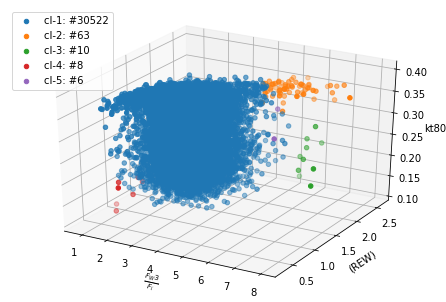

In [16]:
#  -----------3D--------------
# X = np.array(list(zip(FW3Fi, rew, kt80)))
X = np.array(list(zip(iW3, np.log10(rew), (kt80))))
X_tr, minData, rangeData = MinMaxScaler(X)
ERQ_sc = X_tr[(iW3>4.6) & (rew>2)]
ERQ = X[(iW3>4.6) & (rew>2)]
#  ----------AGG----------------
link='average'
for ncl in range(5,6): # number of clusters 
    print(ncl, link)
    model = AgglomerativeClustering(n_clusters=ncl, linkage=link, 
                                        affinity='euclidean').fit(X_tr)
    labels = model.labels_
    colors = ['C0', 'C1', 'C2','C3', 'C4', 'C5', 'C6', 'C7', 'C8']
#     color_code=[]
#     for i in range(len(X)):
#         color_code.append(colors[labels[i]])
    cl_pop=np.zeros([ncl])
    cl_pop=np.array(cl_pop, dtype=np.int64)
    for i in range(len(labels)):
        for j in range(ncl):
            if labels[i]==j:
                cl_pop[j]+=1
    np.savetxt('ncl-%d/3d-link-%s-cl_label-ncl-%d.txt' %(ncl, link,ncl), labels)
    np.savetxt('ncl-%d/3d-link-%s-cl_pop-ncl-%d.txt' %(ncl, link, ncl), cl_pop)

#  3d plotting
    f = plt.figure()
    ax = Axes3D(f)
    ax.cla()
    for cluster in range(ncl):
        X_plot = X[labels==cluster]
        ax.scatter(X_plot[:,0], X_plot[:,1], X_plot[:,2], label='cl-%d: #%d' %(cluster+1, cl_pop[cluster]),
                  c= colors[cluster])
#     ax.scatter(X[:,0], X[:,1], X[:,2], c=color_code, alpha=0.5, s=4)
    ax.set_xlabel(r'$\frac{F_W3}{F_i}$')
    ax.set_ylabel('(REW)')
    ax.set_zlabel('kt80')
    ax.legend()
    plt.savefig('ncl-%d/3d-agg-%d-cl-link-%s.pdf' %(ncl, ncl, link))

   

In [17]:
ncl=1
print(np.min(kt80[labels==ncl]), np.max(kt80[labels==ncl]), np.median(kt80[labels==ncl]))
print(np.min(rew[labels==ncl]), np.max(rew[labels==ncl]), np.median(rew[labels==ncl]))
print(np.min(iW3[labels==ncl]), np.max(iW3[labels==ncl]), np.median(iW3[labels==ncl]))

0.3285508610152268 0.37236881560771967 0.3657267056742276
49.809140264078835 415.2448973790125 141.71032541248633
4.732179338999998 8.014450848000003 5.573301880999999


In [11]:
print(np.min(kt80[labels==2]), np.max(kt80[labels==2]), np.median(kt80[labels==2]))
print(np.min(rew[labels==2]), np.max(rew[labels==2]), np.median(rew[labels==2]))
print(np.min(iW3[labels==2]), np.max(iW3[labels==2]), np.median(iW3[labels==2]))

0.3024636457870353 0.37241841068930853 0.3615205251507676
10.135699982263478 415.2448973790125 97.56219115347618
3.5969583299999996 8.014450848000003 4.818639759


In [28]:
# -------------Med-Spec-3D---------------------------------
# juct for ncl=4
link= "average"
ncl=4
## Define a log wavelength grid for the composite spectrum
step = 1.00015
bb = arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)
nqsos = len(z_dr12)

labels= np.loadtxt('ncl-%d/3d-link-%s-cl_label-ncl-%d.txt' %(ncl, link, ncl))
cl_pop = np.loadtxt('ncl-%d/3d-link-%s-cl_pop-ncl-%d.txt' %(ncl, link, ncl))

# np.min(X[labels==0], axis=0)


for cl_label in range(ncl):
    print('cl_label:', cl_label, 'cl_pop:', cl_pop[cl_label])

    sp = zeros([int(cl_pop[cl_label]), nw])
    k=-1
    for i in notebook.tqdm(range(nqsos)):
        if(labels[i]==cl_label):
            k+=1
        # Retrieve the spectra:
            file = '/home/reza/erq/fred/sdss/%d/spec-%d-%d-%04d.fits' \
            % (plate[i], plate[i],mjd[i],fiberid[i])
            spec = readDR10spec(file)
            wave = spec['wl']
            wz = wave/(z_dr12[i]+1)
            flux = spec['flux']
            mask = (wz > 1680.0) & (wz < 1730.0)
            fnorm = median(flux[mask])
            fluxn = flux/fnorm
        # interpolate the rest-frame spectrum onto the standard grid
            f = interpolate.interp1d(wz,fluxn,bounds_error=False,fill_value=float('nan'))
            sp[k] = f(wgrid)
        # calculate the median spectrum

    med1 = nanmedian(sp,axis=0)
    savetxt( 'ncl-%d/3d-link-%s-agg-medspec-nCl-%d-cl_label-%d.txt' %(link, ncl, ncl, cl_label), med1)

array([4.35258182, 0.93674876, 0.32772634])

4 average


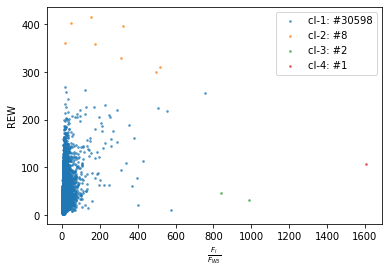

In [21]:
# --------------2D----------------
X = np.array(list(zip(FW3Fi, rew)))
X_tr, minData, rangeData = MinMaxScaler(X)
ERQ_sc = X_tr[(iW3>4.6) & (rew>2)]
ERQ = X[(iW3>4.6) & (rew>2)]
#  Agg. cluster 2D
link='average'
for ncl in range(4,5): # number of clusters 
    print(ncl, link)
    model = AgglomerativeClustering(n_clusters=ncl, linkage=link, 
                                        affinity='euclidean').fit(X_tr)
    labels = model.labels_
    colors = ['C0', 'C1', 'C2','C3', 'C4', 'C5', 'C6', 'C7', 'C8']
    color_code=[]
    for i in range(len(X)):
        color_code.append(colors[labels[i]])
    cl_pop=np.zeros([ncl])
    cl_pop=np.array(cl_pop, dtype=np.int64)
    for i in range(len(labels)):
        for j in range(ncl):
            if labels[i]==j:
                cl_pop[j]+=1
    np.savetxt('ncl-%d/2d-cl_label-ncl-%d-link-%s.txt' %(ncl, ncl, link), labels)
    np.savetxt('ncl-%d/2d-cl_pop-ncl-%d-link-%s.txt' %(ncl, ncl, link), cl_pop)
#     2D plotting
    plt.clf()
    plt.cla()
    for cluster in range(ncl):
        X_plot = X[labels==cluster]
        plt.scatter(X_plot[:,0], X_plot[:,1], label='cl-%d: #%d' %(cluster+1, cl_pop[cluster]),
                  c= colors[cluster], alpha=0.6, s=3)
    plt.xlabel(r$'F_i/F_{W3}$')
    plt.ylabel('REW')
    plt.legend()
#     plt.axvline(x=4.6, ls='--', lw=2, c='black')
    plt.savefig('ncl-%d/2d-agg-%d-cl-link-%s.pdf' %(ncl, ncl, link))
    plt.show()

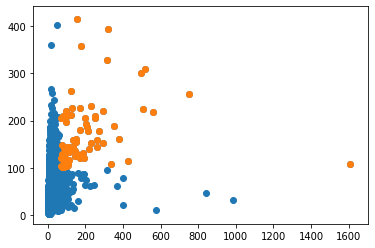

In [19]:
plt.scatter(FW3Fi, rew)
plt.scatter(FW3Fi[(rew>100) & (iW3>4.6)], rew[(rew>100) & (iW3>4.6)])

In [40]:
    
# -------------Med-Spec-   2D--------------------------------
#     ## Define a log wavelength grid for the composite spectrum
step = 1.00015
bb = arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)
nqsos = len(z_dr12)
ncl=4
labels=np.loadtxt('ncl-%d/2d-cl_label-ncl-%d-link-%s.txt' %(ncl, ncl, link))
cl_pop = np.loadtxt('ncl-%d/2d-cl_pop-ncl-%d-link-%s.txt' %(ncl, ncl, link))
for cl_label in range(ncl):
    print('cl_label:', cl_label, 'cl_pop:', cl_pop[cl_label])

    sp = zeros([int(cl_pop[cl_label]), nw])
    k=-1
    for i in notebook.tqdm(range(nqsos)):
        if(labels[i]==cl_label):
            k+=1
        # Retrieve the spectra:
            file = '/home/reza/erq/fred/sdss/%d/spec-%d-%d-%04d.fits' \
            % (plate[i], plate[i],mjd[i],fiberid[i])
            spec = readDR10spec(file)
            wave = spec['wl']
            wz = wave/(z_dr12[i]+1)
            flux = spec['flux']
            mask = (wz > 1680.0) & (wz < 1730.0)
            fnorm = median(flux[mask])
            fluxn = flux/fnorm
        # interpolate the rest-frame spectrum onto the standard grid
            f = interpolate.interp1d(wz,fluxn,bounds_error=False,fill_value=float('nan'))
            sp[k] = f(wgrid)
        # calculate the median spectrum

    med1 = nanmedian(sp,axis=0)
    savetxt( 'ncl-%d/2d-link-%s-agg-medspec-nCl-%d-cl_label-%d.txt' %(ncl, link, ncl, cl_label), med1)

cl_label: 0 cl_pop: 30532.0


/home/reza/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


cl_label: 1 cl_pop: 5.0



cl_label: 2 cl_pop: 40.0


/home/reza/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)



cl_label: 3 cl_pop: 32.0


Calculting Median Spectra

Plotting the median Spectra for each cluster

In [41]:
def line_db(ymax, fs, fs1, ii):
    from numpy import array
    import matplotlib.pyplot as plt
    # some line wavelengths
    s6 = array([933.862,944.523])
    c3 = array([977.020,1175.71,1908.73])
    n3 = array([989.799, 1750.0])
    lyb = 1025.722
    o6 = array([1031.926,1037.617])
    s4 = array([1062.664,1073.518])
    n2 = array([1083.993,1084.580,1085.701,2142.0])
    p5 = array([1117.977,1128.008])
    si3 = array([1206.500,1892.03])
    lya = 1215.670
    he2 = 1640.4
    n4 = 1486.5
    #o4 = array([1397.21,1399.78,1404.79,1407.39])
    o4 = array([1401.157,1407.382])
    n5 = array([1238.821,1242.804])
    si2a = array([1190.416,1193.290,1194.500])
    si2b = array([1260.422,1264.738,1526.7066,1533.4310])
    #o1 = array([1302.1685,1305.0])
    o1 = array([1302.1685,1305.0])
    o1c = 1303.5
    #c2 = array([1334.532,1335.708])
    c2 = array([1334.532,1335.708,2326.0])
    c2c = 1335.0
    si4 = array([1393.755,1402.770])
    c4 = array([1548.195,1550.770])
    fe2 = array([1608.4511, 1786.7])
    fe3 = array([1122.52,1124.87,1128.72,1131.908,1895.46,1914.06,1926.30])
    o3 = 1664.
    al2 = array([1670.7874])
    al3 = array([1854.716,1862.7895])
    mg2 = array([2796.352,2803.531])
    
    # Set the size and aspect ratio of the output pdf plot (in inches) by inserting this command before all other plot commands:
    # This sets the axis ranges:
    plt.ylim(0.0,ymax)
#     plt.xlim(1145,1975)
#     plt.xlim(1145,1675)
    # This uses the wavelength data to draw all the light blue vertical lines in my plot to mark where different lines should be:
    plt.axvline(lya,c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(lyb,c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(he2,c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(o6[0],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(o6[1],c='c',lw=0.6,ls='--', alpha=0.5)
    #plt.axvline(si3[1],c='gold',lw=0.6,ls='--', alpha=1.0)
    plt.axvline(n5[0],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(n5[1],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(n3[1],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(c3[2],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(si2b[0],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(si2b[1],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(si2b[2],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(si2b[3],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(si4[0],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(si4[1],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(o4[0],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(o4[1],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(s4[0],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(s4[1],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(c4[0],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(c4[1],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(c2c,c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(fe2[1],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(fe3[0],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(fe3[1],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(fe3[2],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(fe3[3],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(fe3[4],c='c',lw=0.6,ls='--',alpha=0.5)
    plt.axvline(fe3[5],c='c',lw=0.6,ls='--',alpha=0.5)
    plt.axvline(fe3[6],c='c',lw=0.6,ls='--',alpha=0.5)
    plt.axvline(si3[1],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(o1c,c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(n4,c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(o3,c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(al3[0],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(al3[1],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(mg2[1],c='c',lw=0.6,ls='--', alpha=0.5)
    plt.axvline(mg2[0],c='c',lw=0.6,ls='--', alpha=0.5)
    # This inserts labels for most of the lines near the top of the plot window (where ymax = the top):
    plt.text(1197,  0.94*ymax,'Ly$\\alpha$',ha='center',va='center',fontsize=fs)
    plt.text(1240,  0.97*ymax,'NV',ha='center',va='center',fontsize=fs)
    plt.text(1264,  0.92*ymax,'SiII',ha='center',va='center',fontsize=fs)
    plt.text(1303,  0.95*ymax,'OI',ha='center',va='center',fontsize=fs)
    plt.text(1335,  0.95*ymax,'CII',ha='center',va='center',fontsize=fs)
    plt.text(1399,  0.95*ymax,'SiIV',ha='center',va='center',fontsize=fs1)
    plt.text(1403,  0.9*ymax,'OIV]',ha='center',va='center',fontsize=fs1)
    plt.text(1486,  0.95*ymax,'NIV]',ha='center',va='center',fontsize=fs)
    plt.text(1527,  0.9*ymax,'SiII',ha='center',va='center',fontsize=fs)
    plt.text(1549,  0.95*ymax,'CIV',ha='center',va='center',fontsize=fs)
    if(ii!=3):
        plt.text(1743,  0.93*ymax,'NIII]',ha='center',va='center',fontsize=fs)
        plt.text(1790,  0.93*ymax,'FeII',ha='center',va='center',fontsize=fs)
        plt.text(1625,  0.95*ymax,'HeII',ha='center',va='center',fontsize=fs)
        plt.text(1672,  0.95*ymax,'OIII]',ha='center',va='center',fontsize=fs)
        plt.text(1859,  0.95*ymax,'AlIII',ha='center',va='center',fontsize=fs)
        plt.text(1888,  0.9*ymax,'SiIII]',ha='center',va='center',fontsize=fs)
        plt.text(1909,  0.95*ymax,'CIII]',ha='center',va='center',fontsize=fs)
        plt.text(1926,  0.9*ymax,'FeIII',ha='center',va='center',fontsize=fs)

Cl: 0 1000 to 1980
Cl: 1 1000 to 1980
Cl: 2 1000 to 1980
Cl: 3 1000 to 1980
Cl: 0 1150 to 1980
Cl: 1 1150 to 1980
Cl: 2 1150 to 1980
Cl: 3 1150 to 1980
Cl: 0 1150 to 2850
Cl: 1 1150 to 2850
Cl: 2 1150 to 2850
Cl: 3 1150 to 2850
Cl: 0 1150 to 1700
Cl: 1 1150 to 1700
Cl: 2 1150 to 1700
Cl: 3 1150 to 1700


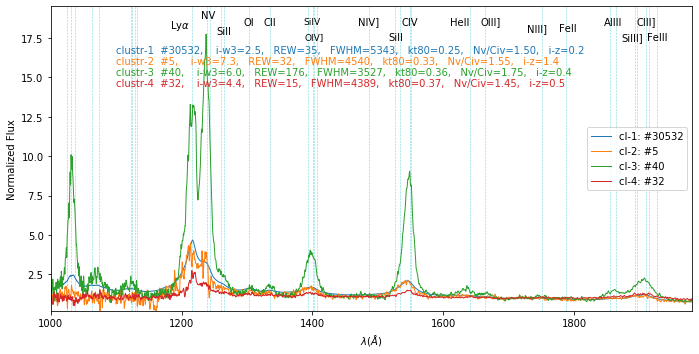

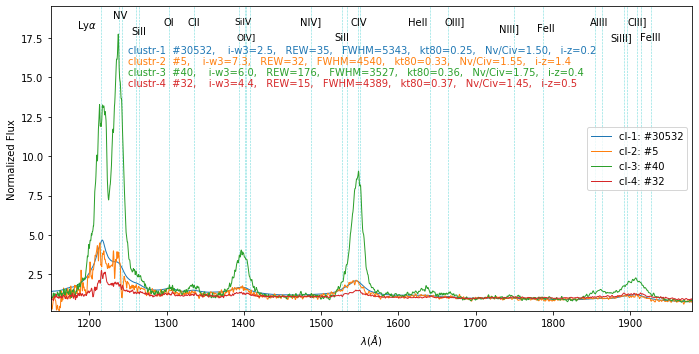

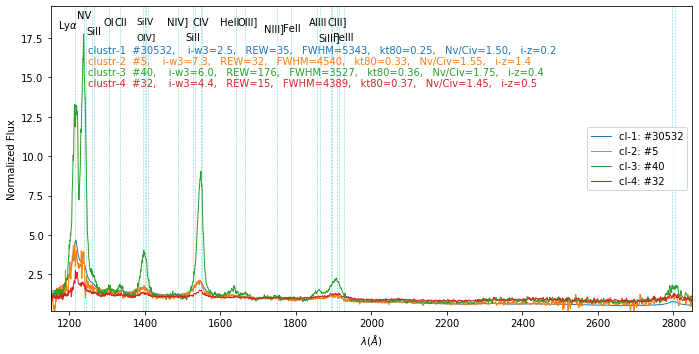

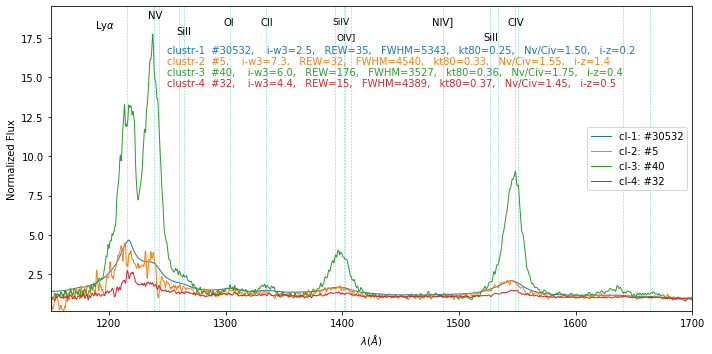

In [44]:
# ----------------2d plot-----------------

## Define a log wavelength grid for the composite spectrum
step = 1.00015
bb = arange(0,8813,1)
wgrid = 800.0 * step**bb

# Insert code here to read data for all possible quasars (redshift, colors, line data, etc.)

from astropy.table import Table, Column
nqsos = len(z_dr12)
c=['C0', 'C1', 'C2','C3', 'C4', 'C5', 'C6', 'C7',  'C8']
j=0
ymax=19.5
ymin=0.01*ymax
fs=10; fs1=9
y_median = 0.93*ymax
med_step=0.7
ncl=4
labels = np.loadtxt('ncl-%d/2d-cl_label-ncl-%d-link-%s.txt' %(ncl, ncl, link))
cl_pop = np.loadtxt('ncl-%d/2d-cl_pop-ncl-%d-link-%s.txt' %(ncl, ncl, link))
for ii in range(0,4):

    if(ii==0): lambda_min = 1000; lambda_max = 1980
    if(ii==1): lambda_min = 1150; lambda_max = 1980
    if(ii==2): lambda_min = 1150; lambda_max = 2850
    if(ii==3): lambda_min = 1150; lambda_max = 1700
    fig = plt.figure(figsize=(11.5,5.6))

    line_db(ymax, fs, fs1, ii)
    plt.ylim(ymin,ymax)
    plt.xlim(lambda_min, lambda_max)
    yb=0
    x_median=lambda_min+100

    for cl_label in range(ncl):

        if (cl_pop[cl_label]>=5):
            yb+=1
            print('Cl:', cl_label, lambda_min, 'to', lambda_max)

            med1=loadtxt('ncl-%d/2d-link-%s-agg-medspec-nCl-%d-cl_label-%d.txt' %(ncl, link, ncl, cl_label))
            plt.ylabel('Normalized Flux')
            plt.xlabel(r'$\lambda  (\AA)$')
            w3_bin=[]
            imw3_bin=[]
            REW_bin=[]
            fwhm_bin=[]
            kt80_bin=[]
            frat_bin=[]
            iz_bin=[]
            Lum_bin=[]

            for i in range(nqsos):
                if(labels[i]==cl_label):
                    w3_bin.append(W3[i]) 
                    imw3_bin.append(iW3[i])
                    REW_bin.append(10**rew[i])
                    fwhm_bin.append(fwhm[i])
                    kt80_bin.append(kt80[i])
                    frat_bin.append(N5_C4[i])
                    iz_bin.append(iz[i])
                    Lum_bin.append(Lum[i])
            if(cl_pop[cl_label]<100):
                sm_med1 = ndimage.filters.gaussian_filter1d(med1,2.0)
            else:
                sm_med1=med1

            # masking for plot ranges
            ind = (wgrid>lambda_min) & (wgrid<lambda_max)
            plt.plot(wgrid[ind],  sm_med1[ind], lw = 1,  c=c[cl_label],
                     label='cl-%d: #%d' %(cl_label+1, cl_pop[cl_label]))
            plt.text(x_median, y_median -(yb+1)*med_step,
                         'clustr-%d  #%d,    i-w3=%.1f,   REW=%d,   FWHM=%d,   kt80=%.2f,   Nv/Civ=%.2f,   i-z=%.1f' 
                         %(cl_label+1, cl_pop[cl_label], np.median(imw3_bin),  
                            np.median(REW_bin), np.median(fwhm_bin),  
                            np.median(kt80_bin), np.median(frat_bin), 
                            np.median(iz_bin)), 
                         ha='left', va='center', color=c[cl_label], fontsize=10)
        plt.legend(loc=7)

        plt.savefig('ncl-%d/2d-link-%s-agg-nCl-%d-med-spec-%d-%d.pdf' %(ncl, link, ncl,  lambda_min, lambda_max), format='pdf',  bbox_inches='tight')
#         plt.savefig('/home/reza/erq/paper/draft/fig/agg-nCl-%d-med-spec-%d-%d.pdf' %(ncl, lambda_min, lambda_max), format='pdf',
#                     bbox_inches='tight')


Cl: 0 1000 to 1980
Cl: 1 1000 to 1980
Cl: 2 1000 to 1980
Cl: 3 1000 to 1980
Cl: 0 1150 to 1980
Cl: 1 1150 to 1980
Cl: 2 1150 to 1980
Cl: 3 1150 to 1980
Cl: 0 1150 to 2850
Cl: 1 1150 to 2850
Cl: 2 1150 to 2850
Cl: 3 1150 to 2850
Cl: 0 1150 to 1700
Cl: 1 1150 to 1700
Cl: 2 1150 to 1700
Cl: 3 1150 to 1700


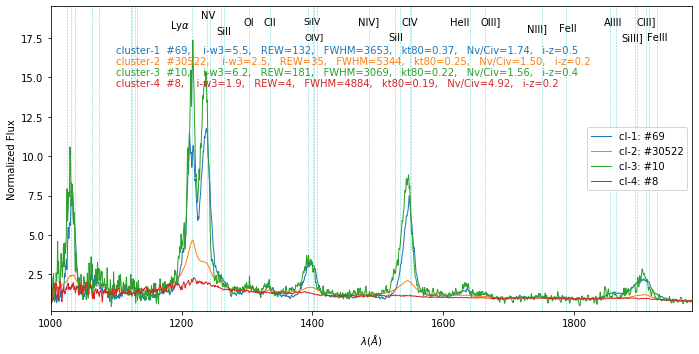

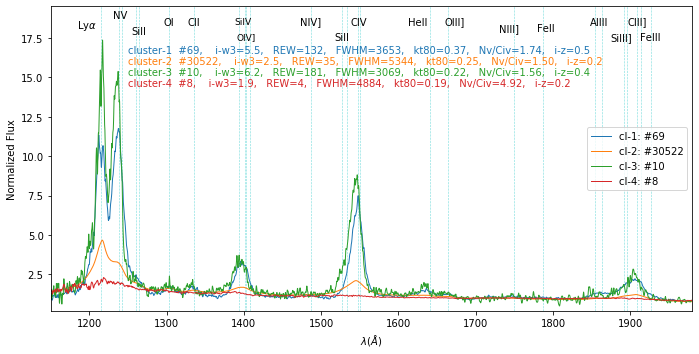

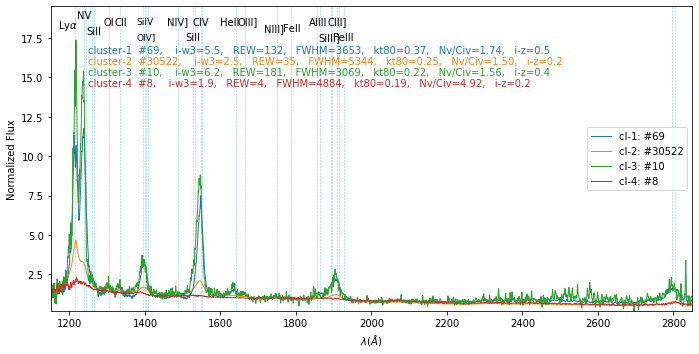

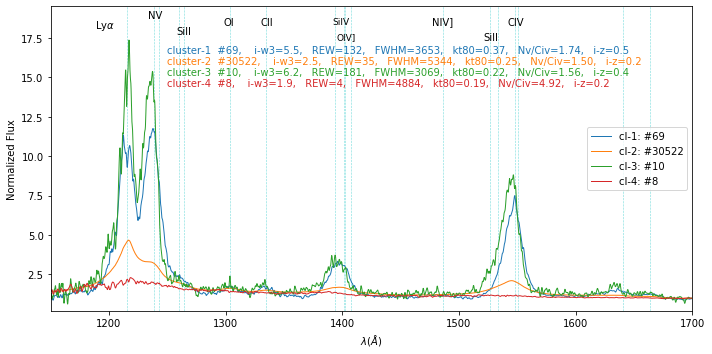

In [33]:
# ----------------3d plot-----------------

## Define a log wavelength grid for the composite spectrum
step = 1.00015
bb = arange(0,8813,1)
wgrid = 800.0 * step**bb

# Insert code here to read data for all possible quasars (redshift, colors, line data, etc.)

from astropy.table import Table, Column
nqsos = len(z_dr12)
colors=['C0', 'C1', 'C2','C3', 'C4', 'C5', 'C6', 'C7',  'C8']
j=0
ymax=19.5
ymin=0.01*ymax
fs=10; fs1=9
y_median = 0.93*ymax
med_step=0.7
ncl=4
labels= np.loadtxt('ncl-%d/3d-link-%s-cl_label-ncl-%d.txt' %(ncl, link, ncl))
cl_pop = np.loadtxt('ncl-%d/3d-link-%s-cl_pop-ncl-%d.txt' %(ncl, link, ncl))
for ii in range(0,4):

    if(ii==0): lambda_min = 1000; lambda_max = 1980
    if(ii==1): lambda_min = 1150; lambda_max = 1980
    if(ii==2): lambda_min = 1150; lambda_max = 2850
    if(ii==3): lambda_min = 1150; lambda_max = 1700
    fig = plt.figure(figsize=(11.5,5.6))

    line_db(ymax, fs, fs1, ii)
    plt.ylim(ymin,ymax)
    plt.xlim(lambda_min, lambda_max)
    yb=0
    x_median=lambda_min+100

    for cl_label in range(ncl):

        if (cl_pop[cl_label]>=5):
            yb+=1
            print('Cl:', cl_label, lambda_min, 'to', lambda_max)
                       
            med1=loadtxt('ncl-%d/3d-link-%s-agg-medspec-nCl-%d-cl_label-%d.txt' %(ncl, link, ncl, cl_label))
            plt.ylabel('Normalized Flux')
            plt.xlabel(r'$\lambda  (\AA)$')
            w3_bin=[]
            imw3_bin=[]
            REW_bin=[]
            fwhm_bin=[]
            kt80_bin=[]
            frat_bin=[]
            iz_bin=[]
            Lum_bin=[]

            for i in range(nqsos):
                if(labels[i]==cl_label):
                    w3_bin.append(W3[i]) 
                    imw3_bin.append(iW3[i])
                    REW_bin.append(10**rew[i])
                    fwhm_bin.append(fwhm[i])
                    kt80_bin.append(kt80[i])
                    frat_bin.append(N5_C4[i])
                    iz_bin.append(iz[i])
                    Lum_bin.append(Lum[i])
            if(cl_pop[cl_label]<100):
                sm_med1 = ndimage.filters.gaussian_filter1d(med1,2.0)
            else:
                sm_med1=med1

            # masking for plot ranges
            ind = (wgrid>lambda_min) & (wgrid<lambda_max)
            plt.plot(wgrid[ind],  sm_med1[ind], lw = 1,  c=colors[cl_label],
                     label='cl-%d: #%d' %(cl_label+1, cl_pop[cl_label]))
            plt.text(x_median, y_median -(yb+1)*med_step,
                         'cluster-%d  #%d,    i-w3=%.1f,   REW=%d,   FWHM=%d,   kt80=%.2f,   Nv/Civ=%.2f,   i-z=%.1f' 
                         %(cl_label+1, cl_pop[cl_label], np.median(imw3_bin),  
                            np.median(REW_bin), np.median(fwhm_bin),  
                            np.median(kt80_bin), np.median(frat_bin), 
                            np.median(iz_bin)), 
                         ha='left', va='center', color=colors[cl_label], fontsize=10)
        plt.legend(loc=7)

        plt.savefig('ncl-%d/3d-agg-link-%s-nCl-%d-med-spec-%d-%d.pdf' %(ncl, link, ncl,  lambda_min, lambda_max), format='pdf',  bbox_inches='tight')
#         plt.savefig('/home/reza/erq/paper/draft/fig/agg-nCl-%d-med-spec-%d-%d.pdf' %(ncl, lambda_min, lambda_max), format='pdf',
#                     bbox_inches='tight')
